In [1]:
#matplotlib notebook
#matplotlib notebook
import yt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from yt.funcs import mylog
mylog.setLevel(0)
mpl.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'text.usetex': True,
    })

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/usr/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [2]:
def make_slice_plot(folder,field,direction='z',set_log=False):
    ds = yt.load(folder)
    slc = yt.SlicePlot(ds,direction,field)
    slc.set_log(field,set_log)
    return slc

def get_mean(folder,field):
    ds = yt.load(folder)
    ad = ds.all_data()
    A = np.array(ad[field])
    return np.mean(A)

def get_covariance(folder,field1,field2):
    ds = yt.load(folder)
    ad = ds.all_data()
    A = np.array(ad[field1])
    B = np.array(ad[field2])
    dA = A - np.mean(A)
    dB = B - np.mean(B)
    return np.mean(dA*dB)

def return_profile(folder,field,direction):
    ds = yt.load(folder)
    ad = ds.covering_grid(level=0, left_edge=ds.domain_left_edge, dims=ds.domain_dimensions)
    mat = ad[field].to_ndarray()
    if direction == 'x':
        A = np.mean(np.mean(mat,axis=1,keepdims=True),axis=2,keepdims=True)
        y = A[:,0,0]
    elif direction == 'y':
        A = np.mean(np.mean(mat,axis=0,keepdims=True),axis=2,keepdims=True)
        y = A[0,:,0]
    elif direction == 'z':
        A = np.mean(np.mean(mat,axis=0,keepdims=True),axis=1,keepdims=True)
        y = A[0,0,:]
    return y

def Yk_to_Xk(Yk,molmass):
    molmix = np.sum(Yk/molmass)
    Xk = (1.0/molmix)*Yk/molmass
    return Xk

def get_hcv(dof,molmass):
    Runiv = 8.314462175e7
    hcv = 0.5*dof*Runiv/molmass
    return hcv

def radial_average(data):
    # create array of radii
    x,y = np.meshgrid(np.arange(data.shape[1]),np.arange(data.shape[0]))
    R = np.sqrt(x**2+y**2)
    # calculate the mean
    f = lambda r : data[(R >= r-.5) & (R < r+.5)].mean()
    r  = np.linspace(1,63,num=63)
    mean = np.vectorize(f)(r)
    return r, mean

def return_profile(folder,field,direction):
    ds = yt.load(folder)
    ad = ds.covering_grid(level=0, left_edge=ds.domain_left_edge, dims=ds.domain_dimensions)
    mat = ad[field].to_ndarray()
    if direction == 'x':
        A = np.mean(np.mean(mat,axis=1,keepdims=True),axis=2,keepdims=True)
        y = A[:,0,0]
    elif direction == 'y':
        A = np.mean(np.mean(mat,axis=0,keepdims=True),axis=2,keepdims=True)
        y = A[0,:,0]
    elif direction == 'z':
        A = np.mean(np.mean(mat,axis=0,keepdims=True),axis=1,keepdims=True)
        y = A[0,0,:]
    return y

def return_profile_average(folder,field,first,last,step,direction):
    flag = 1
    folder_i = folder+'/plt' + '{:09d}'.format(first)
    y = return_profile(folder_i,field,direction)
    y = y[np.newaxis,:]
    for i in np.arange(first+step,last+step,step):
        folder_i = folder+'/plt' + '{:09d}'.format(i)
        y_temp = return_profile(folder_i,field,direction)
        y_temp = y_temp[np.newaxis,:]
        y = np.append(y,y_temp,axis=0)
        flag = flag + 1
    ymean = np.mean(y,axis=0)
    ystd = np.std(y,axis=0)
    return ymean,ystd

In [3]:
def structure_factors_3D(folder,folderplt,vol,xyz_cells,mass,savepng=0):

    kb = 1.38064852e-16

    ds = yt.load(folderplt)
    ad = ds.all_data()
    rhomean = np.mean(np.array(ad["rhoMean"]))
    pmean = np.mean(np.array(ad["pMean"]))
    tmean = np.mean(np.array(ad["tMean"]))
    y1mean = np.mean(np.array(ad["YkMean_0"]))
    
    ## Print the static structure factors
    ## <vv*> <vc*>
    ## <v*c> <cc*>
    ds = yt.load(folder)
    ad = ds.all_data()

    # v-v
    fig,ax = plt.subplots(nrows=2,ncols=2)
    A = np.array(ad["struct_fact_velFACEx_velFACEx"])
    B = np.reshape(A,(xyz_cells[0],xyz_cells[1],xyz_cells[2]))
    C = B[:,:,0]
    C = (C*rhomean/(kb*tmean*vol))
    #ax[0][0].imshow(C.transpose(),vmin=0.8,vmax=1.2,cmap='coolwarm')
    ax[0][0].imshow(C.transpose(),cmap='coolwarm')
    ax[0][0].set_title(r"$\rho<\delta v_{x}^{*} \delta v_{x}>\Delta V/(k_B T)$")

    # v-c
    A = np.array(ad["struct_fact_velCCx_Y1"])
    B = np.reshape(A,(xyz_cells[0],xyz_cells[1],xyz_cells[2]))
    C = B[:,:,0]
    C = (C/vol)
    #ax[0][1].imshow(C.transpose(),vmin=0.8,vmax=1.2,cmap='coolwarm')
    ax[0][1].imshow(C.transpose(),cmap='coolwarm')
    ax[0][1].set_title(r"$<\delta v_{x}^{*} \delta c>\Delta V$")

    # c-v
    A = np.array(ad["struct_fact_Y1_velFACEx"])
    B = np.reshape(A,(xyz_cells[0],xyz_cells[1],xyz_cells[2]))
    C = B[:,:,0]
    C = (C/vol)
    #ax[0][1].imshow(C.transpose(),vmin=0.8,vmax=1.2,cmap='coolwarm')
    ax[1][0].imshow(C.transpose(),cmap='coolwarm')
    ax[1][0].set_title(r"$<\delta c^{*} \delta v_{x}>\Delta V$")
    
     # c-c
    A = np.array(ad["struct_fact_Y1_Y1"])
    B = np.reshape(A,(xyz_cells[0],xyz_cells[1],xyz_cells[2]))
    C = B[:,:,0]
    C = (C*rhomean/(y1mean*(1-y1mean)*mass*vol))
    #ax[0][1].imshow(C.transpose(),vmin=0.8,vmax=1.2,cmap='coolwarm')
    ax[1][1].imshow(C.transpose(),cmap='coolwarm')
    ax[1][1].set_title(r"$\rho<\delta c^{*} \delta c>\Delta V/(m c (1-c))$")
    
    for i in range(2):
        for j in range(2):
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
            ax[i][j].set_xticklabels([])
            ax[i][j].set_yticklabels([])

    ax[1][0].set_xlabel(r"$k_x$")
    ax[1][1].set_xlabel(r"$k_x$")
    ax[0][0].set_ylabel(r"$k_y$")
    ax[1][0].set_ylabel(r"$k_y$")
    plt.show()


def structure_factors_2D_kx(folder,folderplt,xyz_cells,ky_ind,sfname,norm=1.0,plotfig=0,savepng=0):
    
    kb = 1.38064852e-16

    ds = yt.load(folderplt)
    ad = ds.all_data()
    rhomean = np.mean(np.array(ad["rhoMean"]))
    pmean = np.mean(np.array(ad["pMean"]))
    tmean = np.mean(np.array(ad["tMean"]))
    y1mean = np.mean(np.array(ad["YkMean_0"]))
    
    ## Print the static structure factors
    ## <vv*> <vc*>
    ## <v*c> <cc*>
    ds = yt.load(folder)
    # ad = ds.covering_grid(level=0,left_edge=[0.,0.,0.],dims=xyz_cells)
    ad = ds.covering_grid(level=0, left_edge=ds.domain_left_edge, dims=ds.domain_dimensions)
    
    A = np.array(ad[sfname])
    B = np.reshape(A,(xyz_cells[0],xyz_cells[1],xyz_cells[2]))
    y = B[int(xyz_cells[0]/2)+1:,ky_ind,0]
    y = y/norm
    
    x = np.arange(1,int(xyz_cells[0]/2))
    
    if (plotfig):
        fig,ax = plt.subplots()
        ax.scatter(x,y)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r"$k_x$")
        ax.set_xlabel(r"$S(k_x)$")
        plt.show()
    
    return x, y

def structure_factors_transverse(folder,folderplt,xyz_cells,sfname,norm=1.0,plotfig=0,savepng=0):
    
    kb = 1.38064852e-16

    ds = yt.load(folderplt)
    ad = ds.all_data()
    #rhomean = np.mean(np.array(ad["rhoMean"]))
    #pmean = np.mean(np.array(ad["pMean"]))
    #tmean = np.mean(np.array(ad["tMean"]))
    #y1mean = np.mean(np.array(ad["YkMean_0"]))
    
    ## Print the static structure factors
    ## <vv*> <vc*>
    ## <v*c> <cc*>
    #ds = yt.load(folder)
    # ad = ds.covering_grid(level=0,left_edge=[0.,0.,0.],dims=xyz_cells)
    ad = ds.covering_grid(level=0, left_edge=ds.domain_left_edge, dims=ds.domain_dimensions)
    
    A = np.array(ad[sfname])
    B = np.reshape(A,(xyz_cells[0],xyz_cells[1],xyz_cells[2]))
    y = B[int(xyz_cells[0]/2),int(xyz_cells[1]/2)+1:,0]
    print(y)
    y = y/norm
    
    x = np.arange(1,int(xyz_cells[1]/2))
    
    if (plotfig):
        fig,ax = plt.subplots()
        ax.scatter(x,y)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r"$k_x$")
        ax.set_xlabel(r"$S(k_x)$")
        plt.show()
    
    return x, y

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


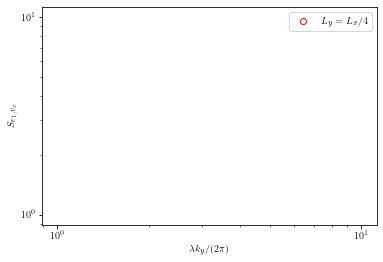

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


In [12]:
folderplt = "~/gigan/projects/FHDeX/exec/DSMC/plt_SF_prim_mag000042000/"
folder    = "~/gigan/projects/FHDeX/exec/DSMC/"

time = "plt_SF_prim_mag000042000"

#sfname = "struct_fact_Y1_velFACEx"
#sfname = "struct_fact_rhoInstant_00_uInstant_00"
#sfname = "struct_fact_uInstant_rhoInstant_00"
sfname = "struct_fact_uInstant_00_cInstant_00"

Nx = 256; Ny = 32; Nz = 4
xyz_cells = [256,32,4]
dx = 1.252e-5; vol = dx**3
mass = 39.9480*1.38064852e-16/8.314462175e7 # mass of gas atom

#ds = yt.load("~/giganScratch/SFtest2/"+time)
#ad = ds.all_data()
#rhomean = np.mean(np.array(ad["rhoMean"]))
#tmean = np.mean(np.array(ad["tMean"]))

fig,ax = plt.subplots()

x, y = structure_factors_transverse(folder,"~/gigan/projects/FHDeX/exec/DSMC/"+time,xyz_cells,sfname,norm=vol)
x = x/(2.0*Ny)
ax.scatter(x,y,edgecolors='red',color='white',marker='o',label=r"$L_{y}=L_{x}/4$",zorder=1000)

#folderplt = 'RB/Lx512/Ly128/plt009999999/'
#folder    = 'RB/Lx512/Ly128/plt_SF_prim_2D_mag010000000/'

#Nx = 256; Ny = 64; Nz = 1
#xyz_cells = [256,64,1]
#dx = 1.252e-5; vol = dx**3
#mass = 39.9480*1.38064852e-16/8.314462175e7 # mass of gas atom

#ds = yt.load(folderplt)
#ad = ds.all_data()
#rhomean = np.mean(np.array(ad["rhoMean"]))
#tmean = np.mean(np.array(ad["tMean"]))

#x, y = structure_factors_transverse(folder,folderplt,xyz_cells,sfname,norm=vol)
#x = x/(2.0*Ny)
#ax.scatter(x,y,edgecolors='blue',color='white',marker='s',label=r"$L_{y}=L_{x}/2$",zorder=1)


#folderplt = 'RB/Lx512/Ly256/plt006999999/'
#folder    = 'RB/Lx512/Ly256/plt_SF_prim_2D_mag007000000/'

#Nx = 256; Ny = 128; Nz = 1
#xyz_cells = [256,128,1]
#dx = 1.252e-5; vol = dx**3
#mass = 39.9480*1.38064852e-16/8.314462175e7 # mass of gas atom

#ds = yt.load(folderplt)
#ad = ds.all_data()
#rhomean = np.mean(np.array(ad["rhoMean"]))
#tmean = np.mean(np.array(ad["tMean"]))

#x, y = structure_factors_transverse(folder,folderplt,xyz_cells,sfname,norm=vol)
#x = x/(2.0*Ny)
#ax.scatter(x,y,edgecolors='black',color='white',marker='p',label=r"$L_{y}=L_{x}$",zorder=1)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$\lambda k_{y}/(2\pi)$")
ax.set_ylabel(r"$S_{c_{1},v_{x}}$")
plt.legend(loc=0)
plt.show()
print(y)

In [ ]:
folderplt = 'RB/Lx512/Ly64/plt009999999/'
folder    = 'RB/Lx512/Ly64/plt_SF_prim_2D_mag010000000/'

sfname = "struct_fact_Y1_Y1"

Nx = 256; Ny = 32; Nz = 1
xyz_cells = [256,32,1]
dx = 1.252e-5; vol = dx**3
mass = 39.9480*1.38064852e-16/8.314462175e7 # mass of gas atom

ds = yt.load(folderplt)
ad = ds.all_data()
rhomean = np.mean(np.array(ad["rhoMean"]))
tmean = np.mean(np.array(ad["tMean"]))

fig,ax = plt.subplots()

x, y = structure_factors_transverse(folder,folderplt,xyz_cells,sfname,norm=vol)
x = x/(2.0*Ny)
ax.scatter(x,y,edgecolors='red',color='white',marker='o',label=r"$L_{y}=L_{x}/4$",zorder=1000)

folderplt = 'RB/Lx512/Ly128/plt009999999/'
folder    = 'RB/Lx512/Ly128/plt_SF_prim_2D_mag010000000/'

Nx = 256; Ny = 64; Nz = 1
xyz_cells = [256,64,1]
dx = 1.252e-5; vol = dx**3
mass = 39.9480*1.38064852e-16/8.314462175e7 # mass of gas atom

ds = yt.load(folderplt)
ad = ds.all_data()
rhomean = np.mean(np.array(ad["rhoMean"]))
tmean = np.mean(np.array(ad["tMean"]))

x, y = structure_factors_transverse(folder,folderplt,xyz_cells,sfname,norm=vol)
x = x/(2.0*Ny)
ax.scatter(x,y,edgecolors='blue',color='white',marker='s',label=r"$L_{y}=L_{x}/2$",zorder=1)


folderplt = 'RB/Lx512/Ly256/plt006999999/'
folder    = 'RB/Lx512/Ly256/plt_SF_prim_2D_mag007000000/'

Nx = 256; Ny = 128; Nz = 1
xyz_cells = [256,128,1]
dx = 1.252e-5; vol = dx**3
mass = 39.9480*1.38064852e-16/8.314462175e7 # mass of gas atom

ds = yt.load(folderplt)
ad = ds.all_data()
rhomean = np.mean(np.array(ad["rhoMean"]))
tmean = np.mean(np.array(ad["tMean"]))

x, y = structure_factors_transverse(folder,folderplt,xyz_cells,sfname,norm=vol)
x = x/(2.0*Ny)
ax.scatter(x,y,edgecolors='black',color='white',marker='p',label=r"$L_{y}=L_{x}$",zorder=1)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$\lambda k_{y}/(2\pi)$")
ax.set_ylabel(r"$S_{c_{1},v_{x}}$")
plt.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>


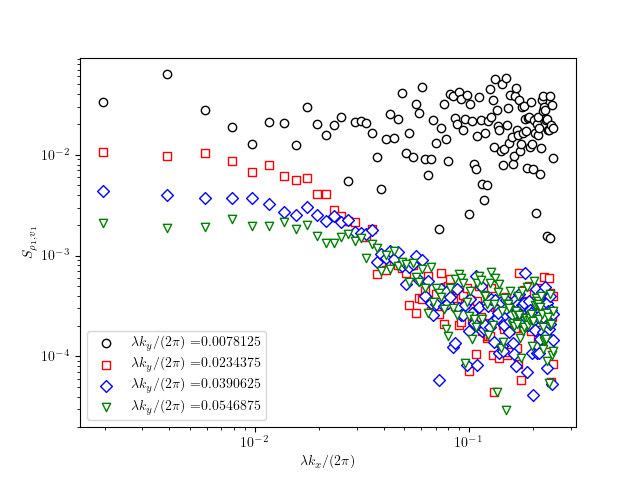

In [8]:
folderplt = 'RB/Lx512/Ly256/plt006999999/'
folder    = 'RB/Lx512/Ly256/plt_SF_prim_2D_mag007000000/'

Nx = 256; Ny = 128; Nz = 1
xyz_cells = [256,128,1]
dx = 1.252e-5; vol = dx**3
mass = 39.9480*1.38064852e-16/8.314462175e7 # mass of gas atom

ds = yt.load(folderplt)
ad = ds.all_data()
rhomean = np.mean(np.array(ad["rhoMean"]))
tmean = np.mean(np.array(ad["tMean"]))

ky_ind = [int(Ny/2), int(Ny/2)+6, int(Ny/2)+10, int(Ny/2)+14]
ky = [2,6,10,14]
marker = ['o','s','D','v']
color = ['black','red','blue','green']

sfname = "struct_fact_Y1_velFACEx"

fig,ax = plt.subplots()
for i in range(4):
    x, y = structure_factors_2D_kx(folder,folderplt,xyz_cells,ky_ind[i],sfname,norm=vol,plotfig=0,savepng=0)
    x = x/(2.0*Nx)
    ax.scatter(x,y,edgecolors=color[i],color='white',marker=marker[i],label=r"$\lambda k_{y}/(2\pi)=$"+str(ky[i]/(2.0*Ny)))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$\lambda k_{x}/(2\pi)$")
ax.set_ylabel(r"$S_{\rho_{1},v_{1}}$")
plt.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>


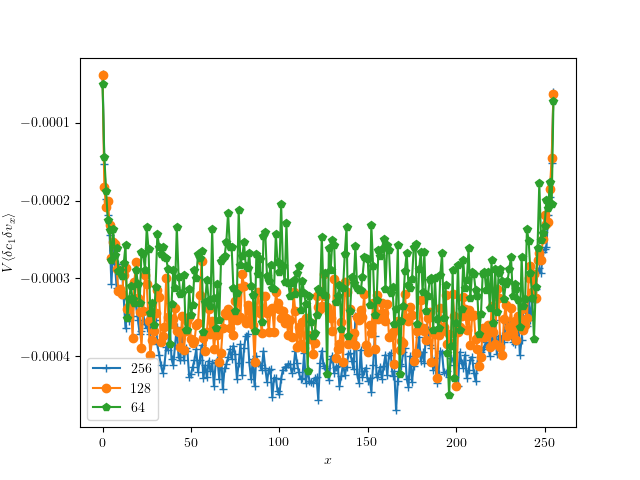

In [12]:
field = "YkL-vx"; DSMCfield = 'TVar'; label = r"$V\langle \delta c_1 \delta v_x \rangle$"
fig = plt.figure();ax = fig.add_subplot(111)
ym, ys = return_profile_average('./RB/Lx512/Ly256/',field,6999999,6999999,5000000,'x')
ax.plot(ym,marker='+',label='256')
ym, ys = return_profile_average('./RB/Lx512/Ly128/',field,9999999,9999999,5000000,'x')
ax.plot(ym,marker='o',label='128')
ym, ys = return_profile_average('./RB/Lx512/Ly64/',field,9999999,9999999,5000000,'x')
ax.plot(ym,marker='p',label='64')
ax.set_ylabel(label)
ax.set_xlabel(r"$x$")
plt.legend(loc=0)
plt.show()